<a href="https://colab.research.google.com/github/ashfarhangi/One_Notebook_For_All/blob/main/5_Working_Sentence_Classification_Pytorch_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !kill -9 -1 # Kill if 
# !nvidia-smi

In [ ]:
%%capture
!pip install -qq transformers
!pip install -qq --upgrade wandb
!wandb login 79c99cb8196ccfc85f75dd926f9e872da3ba85a8
import wandb
wandb.init(project="school",notes='Dec-5_BERT')

# !pip install -qq torch==1.4.0

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pyparsing.py", line 4749, in parseImpl
    return super(ZeroOrMore, self).parseImpl(instring, loc, doActions)
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pyparsing.py", line 4665, in parseImpl
    loc, tokens = self_expr_parse(instring, loc, doActions, callPreParse=False)
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pyparsing.py", line 1669, in _parseNoCache
    loc, tokens = self.parseImpl(instring, preloc

wandb: Currently logged in as: ashfarhangi (use `wandb login --relogin` to force relogin)


In [ ]:
RANDOM_SEED =47
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from collections import defaultdict
from textwrap import wrap
import seaborn as sns
from joblib import load, dump
import pickle
from tqdm import tqdm
import transformers
torch.manual_seed(RANDOM_SEED) 
device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install -qq watermark
%reload_ext watermark
%watermark -v -p numpy,tensorflow,torch,pandas,sklearn,seaborn

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
tensorflow 2.3.0
torch 1.7.0+cu101
pandas 1.1.4
sklearn 0.0
seaborn 0.11.0


In [ ]:
plt.rcParams['figure.figsize'] =(14,8)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
'figure.figsize': (18, 8),
'axes.labelsize': '16',
'axes.titlesize': '16',
'xtick.labelsize':'14',
'ytick.labelsize':'14',
'font.family': 'Times new roman'}
pylab.rcParams.update(params)

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
RANDOM_SEED =47
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 
device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")

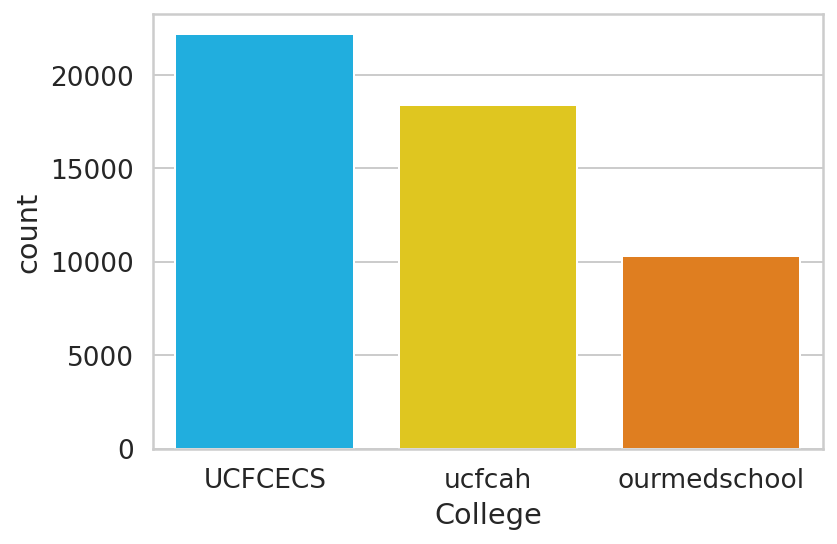

,created_at,school_name,user_name,text,school_handle,tweet_id
0,2020-11-20 17:36:57,UCF Engineering,Brendon_Cavy,Proud boyfriend here. I defended my thesis at ...,UCFCECS,1329841171703754757
1,2020-11-20 15:25:27,UCF Engineering,Brendon_Cavy,RT @Kean_Research: Super proud of @alyssa_mick...,UCFCECS,1329808078750044160
2,2020-11-16 03:42:59,UCF Engineering,Brendon_Cavy,@neggplant Mood,UCFCECS,1328181748111380480
3,2020-11-16 03:41:58,UCF Engineering,Brendon_Cavy,RT @DaveMosher: PSA: Space folks know this is ...,UCFCECS,1328181490413395968
4,2020-11-16 01:19:02,UCF Engineering,Brendon_Cavy,"RT @UCF_Football: Reach for the Stars, #Crew1 ...",UCFCECS,1328145518468472832
...,...,...,...,...,...,...
50849,2020-04-05 04:36:35,UCF Medicine,marcellaftm,RT @GordyPls: Announcement screen on ground fl...,ourmedschool,1246657966075494400
50850,2020-04-05 04:35:05,UCF Medicine,marcellaftm,RT @H2O_SportsMD: Intubation is complete. #Ort...,ourmedschool,1246657586822291457
50851,2020-04-05 04:34:56,UCF Medicine,marcellaftm,RT @McFaul: Is there a reason Trump calls the ...,ourmedschool,1246657552437448707
50852,2020-04-05 04:34:17,UCF Medicine,marcellaftm,RT @ChrisCarrollMD: I don’t know who needs to ...,ourmedschool,1246657385176989697


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/0.NLP_Twitter_&_Complaints/data/dec_5_hand.csv')
df

# df_origin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/0.NLP_Twitter_&_Complaints/data/ucf_college_tweets.csv')
# df_origin.columns = ['created_at','school_name','user_name','text','school_handle','tweet_id']
# col='user_name'
# df = df_origin[df_origin.groupby(col)[col].transform('size') < 200]
df.reset_index(drop=True,inplace=True)
sns.countplot(df.school_handle)
plt.xlabel('College')
plt.show()
df

In [ ]:
#  df = df.sample(5000)
# df.reset_index(drop=True,inplace=True)

Text(0.5, 0, 'College')

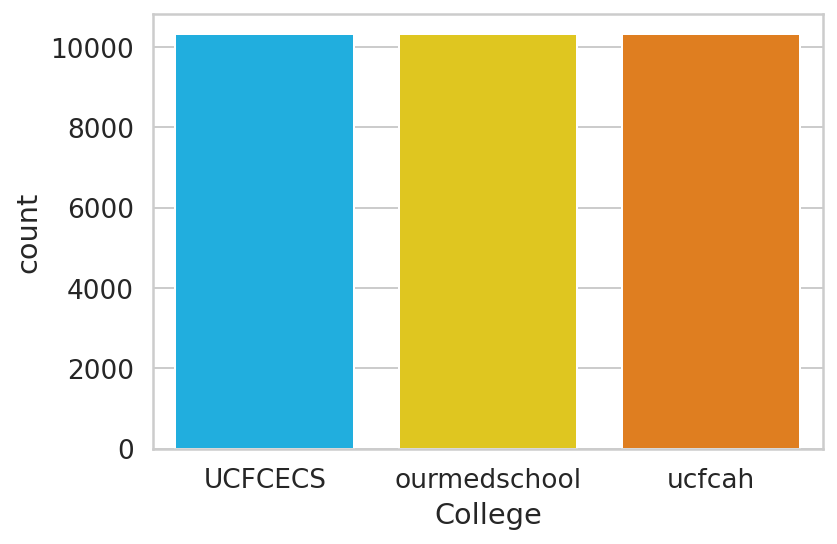

In [ ]:
# from sklearn.utils import resample
# cat_1= df[df.school_handle == 'UCFCECS']
# cat_2= df[df.school_handle == 'ucfcah']

# cat_large = df[df.school_handle == 'ourmedschool']
# cat_1 = resample(cat_1,
#                           replace=True,
#                           n_samples=len(cat_large),
#                           random_state=RANDOM_SEED)
# cat_2 = resample(cat_2,
#                           replace=True,
#                           n_samples=len(cat_large),
#                           random_state=RANDOM_SEED)
# df1 = pd.merge(cat_1,cat_large,how='outer')
# df1 = pd.merge(df1,cat_2,how='outer')
# df1
# sns.countplot(df1.school_handle)
# plt.xlabel('College')
cat_small =  df[df.school_handle == 'ourmedschool']
cat_1= df[df.school_handle == 'UCFCECS'].sample(len(cat_small))
cat_2= df[df.school_handle == 'ucfcah'].sample(len(cat_small))

df1 = pd.merge(cat_1,cat_small,how='outer')
df1 = pd.merge(df1,cat_2,how='outer')
sns.countplot(df1.school_handle)
plt.xlabel('College')

Text(0.5, 0, 'College')

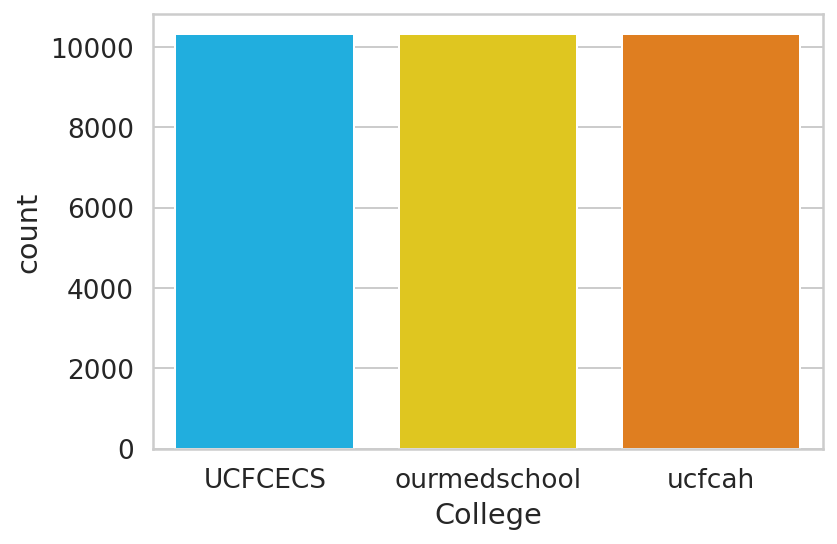

In [ ]:
# df1 = df1.sample(2000)

sns.countplot(df1.school_handle)
plt.xlabel('College')


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['label']= le.fit_transform(df1['school_handle'])


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = 'We are located at University of Central Florida!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f' Tokens: {tokens}')
print(f' Token ids: {token_ids}')

 Sentence: We are located at University of Central Florida!
 Tokens: ['We', 'are', 'located', 'at', 'University', 'of', 'Central', 'Florida', '!']
 Token ids: [1284, 1132, 1388, 1120, 1239, 1104, 1970, 2631, 106]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length= 32,
    add_special_tokens=True,
    return_token_type_ids =False,
    pad_to_max_length = True,
    return_attention_mask=True,
    return_tensors='pt') # returns pytorch tensors
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
a = encoding['input_ids']
b = encoding['attention_mask']
print(f' Input ids: {a}')
print(f' Attention Masks: {b}')
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

 Input ids: tensor([[ 101, 1284, 1132, 1388, 1120, 1239, 1104, 1970, 2631,  106,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
 Attention Masks: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


['[CLS]',
 'We',
 'are',
 'located',
 'at',
 'University',
 'of',
 'Central',
 'Florida',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []
for txt in tqdm(df1.text):
  tokens = tokenizer.encode(txt,max_length=512)
  token_lens.append(len(tokens))


100%|██████████| 30930/30930 [00:13<00:00, 2323.37it/s]


Text(0.5, 11.552000000000007, 'Token Count')

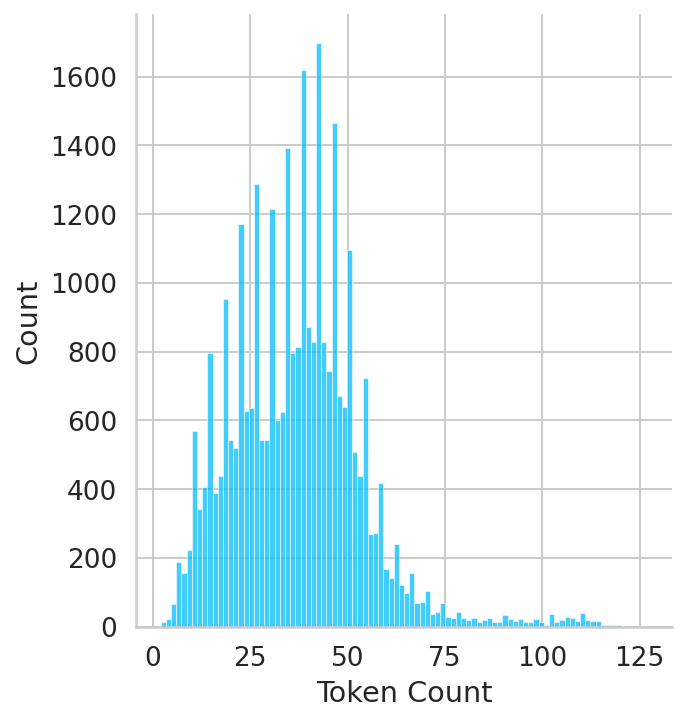

In [ ]:
sns.displot(token_lens)
plt.xlabel('Token Count')

In [ ]:
MAX_LEN = 128

## PyTorch Dataset


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self,text,target,tokenizer,max_len):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
# get item function of pyTorch
  def __getitem__(self,item):
    text = str(self.text[item])
    target = self.target[item]
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids=False,
        pad_to_max_length = True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets':torch.tensor(target,dtype=torch.long)
    }


In [ ]:
df_train, df_test = train_test_split(df1,test_size=0.1,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5, random_state= RANDOM_SEED)
df_train.shape,df_val.shape,df_test.shape

((27837, 7), (1546, 7), (1547, 7))

In [ ]:
# data loader transformers the data into batch data
def create_data_loader(df1, tokenizer,max_len,batch_size):
  ds = Dataset(text = df1.text.to_numpy(),
               target = df1.label.to_numpy(),
               tokenizer = tokenizer,
               max_len = max_len)
  return torch.utils.data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:

len(df_train)

27837

In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [ ]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)[0]
pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)[1]
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
class Classifier(torch.nn.Module):

  def __init__(self,n_classes):
    super(Classifier,self).__init__()
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = torch.nn.Dropout(p=0.5)
    self.out = torch.nn.Linear(self.bert.config.hidden_size,n_classes)

  def forward(self,input_ids, attention_mask):
    _ = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )[0]

    pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
torch.cuda.empty_cache()


In [ ]:
model = Classifier(3) # number of classes in our study is 3
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape,attention_mask.shape)

torch.Size([16, 128]) torch.Size([16, 128])


In [ ]:
# Apply a softmax function from fuctional class of nn
torch.nn.functional.softmax(model(input_ids,attention_mask),dim=1)

tensor([[0.4320, 0.2216, 0.3464],
        [0.2572, 0.1228, 0.6200],
        [0.2391, 0.2476, 0.5134],
        [0.1564, 0.0814, 0.7622],
        [0.3307, 0.1535, 0.5158],
        [0.1832, 0.1547, 0.6620],
        [0.2277, 0.0483, 0.7240],
        [0.1690, 0.2330, 0.5980],
        [0.2582, 0.2375, 0.5043],
        [0.2458, 0.1165, 0.6377],
        [0.1281, 0.3424, 0.5295],
        [0.2801, 0.2892, 0.4307],
        [0.2545, 0.0815, 0.6640],
        [0.1600, 0.1924, 0.6476],
        [0.4108, 0.1842, 0.4050],
        [0.4739, 0.2116, 0.3145]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 3
optimizer = transformers.AdamW(model.parameters(), lr= 2e-5, correct_bias = False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    # print(torch.sum(preds == targets))
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      # print(torch.max(outputs, dim=1))

      loss = loss_fn(outputs, targets)

      # correct_predictions += int(torch.sum(preds == targets))
      correct_predictions += torch.sum(preds == targets)
      #print(correct_predictions)
      losses.append(loss.item())
  # correct_predictions = correct_predictions / BATCH_SIZE
  return correct_predictions.double() / n_examples, np.mean(losses)
  # return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
wandb.watch(model,log='gradients')

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  wandb.log({"Val loss": val_loss})
  wandb.log({"Val accu": val_acc})

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  wandb.log({"Train accu": train_acc})
  wandb.log({"Train loss": train_loss})
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/0.NLP_Twitter_&_Complaints/data/best_model_state.bin'))
model = model.to(device)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(classification_report(y_test, y_pred, target_names=['Engineering','Medical','Arts'
]))


In [ ]:
class_names= ['Engineering','Medical','Arts']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Classification')
  plt.xlabel('Predicted Classification');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
for idx in range(len(y_review_texts)):
  review_text = y_review_texts[idx]
  true_sentiment = y_test[idx]
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
  })
  print("\n".join(wrap(review_text)))
  print()
  print(f'True Prediction: {class_names[true_sentiment]}')
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.title(class_names[true_sentiment],wrap(review_text)[0])
  plt.ylabel('Classification')
  plt.xlabel('Probability')
  plt.xlim([0, 1]);
  plt.show()

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'text: {review_text}')
print(f'class  : {class_names[prediction]}')


# Profile Classificaiton

In [ ]:
# @@
df_profile = df.groupby('user_name')['text'].apply(' '.join).reset_index()
df_profile

In [ ]:
b = df[['user_name','school_handle']]
b= b.drop_duplicates().reset_index(drop=True)

In [ ]:
df_profile = df_profile.merge(b,how='left',on=['user_name'])


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_profile['labels']= le.fit_transform(df_profile['school_handle'])
df_profile = df_profile.sample(len(df_profile),random_state=47)
df_profile.reset_index(drop=True,inplace=True)

In [ ]:
df_profile

In [ ]:
news_groups = ['Eng','Med','Art']

In [ ]:
import sklearn
X = df_profile.text
y= df_profile.labels
X_train,X_test,y_train,y_test= train_test_split(X,y,stratify=y,test_size=0.3, 
)
print('number of training samples:', len(X_train))
print('number of test samples:', len(X_test))
train_df = pd.DataFrame({'doc':X_train,
                         'labels':y_train})
test_df = pd.DataFrame({'doc':X_test,
                         'labels':y_test})
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [ ]:
!pip -qq install transformers==3.3.1
!pip -qq install pkbar
import os
import re
import collections
import timeit
import torch
import pandas as pd
import pkbar
import numpy
# import numpy.testing.decorators
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from sklearn.metrics import  f1_score,classification_report


In [ ]:
# Uses GPU if available
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Distil-bert model parameters
from transformers import DistilBertConfig,DistilBertTokenizer,DistilBertModel
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 1e-05
num_classes = len(df_profile.labels.unique())
num_of_batches_per_epoch = len(X_train)//TRAIN_BATCH_SIZE
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
class BertDataFormat(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        cur_doc = str(self.data.doc[index])
        cur_doc = " ".join(cur_doc.split())
        inputs = self.tokenizer.encode_plus(
            cur_doc,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.labels[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

training_set = BertDataFormat(train_df, tokenizer, MAX_LEN)
testing_set = BertDataFormat(test_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# !pip install transformers

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self,num_classes):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        bert_last = hidden_state[:, 0]
        output = self.classifier(bert_last)
        return output

In [ ]:
# Copy model to device.
baseline_model = DistillBERTClass(num_classes)
baseline_model.to(device)

In [ ]:
# Create the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  baseline_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Calcuate accuracy of the model
def acc_cal(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# train model
def train(epoch,model):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()

    # progress bar
    train_per_epoch = num_of_batches_per_epoch
    kbar = pkbar.Kbar(target=train_per_epoch, epoch=epoch, 
                      num_epochs=EPOCHS, width=8, 
                      always_stateful=False)

    for idx,data in enumerate(training_loader, 0):

        # copy tensors to gpu
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        # get output and calculate loss.
        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += acc_cal(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
      
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()
        kbar.update(idx, values=[("train_loss", tr_loss/(idx+1))])

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    history['train_acc'].append(epoch_accu)
    history['train_loss'].append(epoch_loss)

    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
# function to predict output.
def valid(model, testing_loader):
    predicted_labels = []
    true_labels = []
    nb_tr_steps = 0
    tr_loss =0
    nb_tr_examples=0
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):

            # copy tensors to gpu.
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()

            # calculate loss
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            predicted_labels += big_idx
            true_labels += targets
            
            n_correct += acc_cal(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    history['val_acc'].append(epoch_loss)
    history['val_loss'].append(epoch_accu)    
    return epoch_accu,epoch_loss,predicted_labels,true_labels

In [ ]:
for epoch in range(EPOCHS):
    history = defaultdict(list)

    train(epoch,baseline_model)
    print('\n')

In [ ]:
history = defaultdict(list)


In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [ ]:
acc,loss,predicted_labels,true_labels = valid(baseline_model, testing_loader)
print("test accuracy on baseline distilbert model =",round(acc,2))

In [ ]:
predicted_labels = [i.item() for i in predicted_labels]
true_labels = [i.item() for i in true_labels]
baseline_f1 = f1_score(true_labels,predicted_labels,average='macro')
print("F1 score on baseline model = ",baseline_f1)

In [ ]:
print(classification_report(true_labels,predicted_labels,target_names=news_groups))

In [ ]:
# @@

# Distil-bert model parameters
from transformers import DistilBertConfig,DistilBertTokenizer,DistilBertModel
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 1e-05
# num_classes = len(df_profile.labels.unique())
num_of_batches_per_epoch = len(X_train)//TRAIN_BATCH_SIZE
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
class DocBERTClass(torch.nn.Module):
    def __init__(self):
        super(DocBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dimension = 64
        #self.lstm = nn.LSTM(input_size=768, hidden_size=dimension,num_layers=1,
        #                    bidirectional=True)
        hidden_dim = 64 
        embed_dim = 768

        self.lstm  = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.pre_classifier = torch.nn.Linear(64, 64)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(64, 20)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        bert_final = hidden_state[:, 0]
        bert_final = bert_final.squeeze().unsqueeze(dim=0)
        lstm1, (h, c) = self.lstm(bert_final)
        #print(lstm1.shape)
        lstm1 = lstm1.view((lstm1.shape)[1],64)
        linear1 = self.pre_classifier(lstm1)
        linear1 = torch.nn.ReLU()(linear1)
        linear1 = self.dropout(linear1)
        #print(linear1.shape)
        output = self.classifier(linear1)
        #print(output.shape)
        return output

In [ ]:
# Copy model to device.
docbert_model = DocBERTClass()
docbert_model.to(device)

In [ ]:
# Create the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  docbert_model.parameters(), lr=LEARNING_RATE)

In [ ]:
print('DocBert Model')
EPOCHS = 8
for epoch in range(EPOCHS):
    train(epoch,docbert_model)
    print('\n')

In [ ]:
acc,loss,predicted_labels,true_labels = valid(docbert_model, testing_loader)
print("test accuracy on DocBert model =",acc, '%')

In [ ]:
predicted_labels = [i.item() for i in predicted_labels]
true_labels = [i.item() for i in true_labels]
docbert_f1 = f1_score(true_labels,predicted_labels,average='macro')
print("F1 score on docbert model = ",docbert_f1)

In [ ]:
print(classification_report(true_labels,predicted_labels,target_names=news_groups))

## Classic ML

In [ ]:
# @@@

import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
# Setting the vectorizer just like we would set a model

cvec = CountVectorizer()

# Fitting the vectorizer on our training data

cvec.fit(X_train)

In [ ]:
# Lets check the length of our data that is in a vectorized state

len(cvec.get_feature_names())

One of the features included by CountVectorizer is the in-built tool of stop_words. In NLP, stop words are words which are filtered out usually after processing our data. Though stop_words in this case refers to the most common words in a language (and more often than not, this is the case). there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list.

In [ ]:
# Lets use the stop_words argument to remove words like "and, the, a"

cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data

cvec.fit(X_train)

# Transform training data

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [ ]:
X_test_cvec = cvec.transform(X_test)

#### Fit a logistic regression model

In [ ]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr',max_iter=1000)
lr.fit(X_train_cvec, y_train)
print(lr.score(X_train_cvec, y_train))
print(lr.score(X_test_cvec, y_test))

In [ ]:
def docm(y_true, y_pred,labels):
    cm = confusion_matrix(y_true, y_pred)
    cols = ['p_'+c for c in labels]
    df = pd.DataFrame(cm, index=labels, columns=cols)
    return df
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Classification')
  plt.xlabel('Predicted Classification');


In [ ]:
class_names= ['Engineering','Medical','Arts']

cm = confusion_matrix(y_test, lr.predict(X_test_cvec))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
docm(y_test,lr.predict(X_test_cvec),labels=news_groups)


Classification report of cbow and logistic regression model

In [ ]:
print(classification_report(y_test,lr.predict(X_test_cvec),target_names=news_groups))

### Model 2:  tf-idf + logistic regression

In [ ]:
piped_model_2 = make_pipeline(TfidfVectorizer(stop_words='english',
                                      #sublinear_tf=True,
                                      max_df=0.3,
                                      max_features=4000),
                      LogisticRegression())
piped_model_2.fit(X_train, y_train)
y_pred = piped_model_2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(piped_model_2.steps[0][1].get_feature_names()))

Classification report of tf-idf + logistic regression model

In [ ]:
print(classification_report(y_test,y_pred,target_names=news_groups))

### Model 3: tf-df + SVM

In [ ]:
tvec = TfidfVectorizer(stop_words='english',
                       max_df=0.5,
                       max_features=1000)

In [ ]:
tvec.fit(X_train)
X_train_tvec = tvec.transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [ ]:
# Parameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'linear']}
grid = GridSearchCV(SVC(),param_grid)
grid.fit(X_train_tvec,y_train)
print(grid.best_estimator_)

In [ ]:
# Best fit
model = SVC(gamma=0.01,kernel='rbf',C=0.1)
model.fit(X_train_tvec, y_train)
y_pred = model.predict(X_test_tvec)
score = accuracy_score(y_test, y_pred)
score

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
cm = docm(y_test, y_pred, news_groups)
cm

Classification report of tf-idf + SVM model

In [ ]:
print(classification_report(y_test,y_pred,target_names=news_groups))

References:

Get S done with pytorch 
